<a href="https://colab.research.google.com/github/biniyam-mulugeta/test_co_2/blob/main/Kfold%20with%20confusion_final5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np 
import keras
from keras.models import Model
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,DepthwiseConv2D,Add#,Dense,Dropout,Conv2D
from keras.applications import densenet,mobilenet, mobilenet_v2,efficientnet#densenetmobilenet_v2#,efficientnet,vgg16,densenet
from keras.applications import vgg19,resnet
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
#from keras.utils.all_utils import to_categorical
from sklearn import preprocessing
from skimage.filters import threshold_otsu
import cv2
from pathlib import Path
import os
import glob
import matplotlib.pyplot as plt
#import seaborn as sns
#import zipfile
%matplotlib inline

In [3]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score,GridSearchCV,StratifiedShuffleSplit
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from skimage import io

In [4]:
from keras.layers import Flatten,concatenate,GlobalAveragePooling2D,Input,Dense,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization
from keras.layers import MaxPool2D,AveragePooling2D

In [5]:
import pandas as pd

In [6]:
SIZE = 32
data_image = []
data_label = []
for dir_path in glob.glob("/content/drive/My Drive/coffee_dataset/*"):
    label = dir_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        print(img_path)
        img = cv2.imread(img_path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(SIZE,SIZE))
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        
        img = cv2.GaussianBlur(img,(5,5),0)
  
        #img = otsu_segmentation(img)]

        data_image.append(img)
        data_label.append(label)
data_image = np.array(data_image)
data_label = np.array(data_label)

Streaming output truncated to the last 5000 lines.
/content/drive/My Drive/coffee_dataset/phoma_cro/456_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_5.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_6.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_7.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/456_8.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_1.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_2.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_3.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/458_4.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/460.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461.jpg
/content/drive/My Drive/coffee_dataset/phoma_cro/461_1.jpg
/content/dr

In [7]:
le = preprocessing.LabelEncoder()
le.fit(data_label)
train_labe_encoded = le.transform(data_label)

In [8]:
x_train,y_train = data_image,train_labe_encoded
x_train = x_train/255.0

In [9]:
from keras.utils.all_utils import to_categorical
y_train_one_hot = to_categorical(y_train)

### train test validate splite

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_tr,x_te,y_tr,y_te = train_test_split(x_train,y_train,test_size=0.20,shuffle=True,random_state=42)

In [12]:
print(x_tr.shape,'----',y_tr.shape)
print(x_te.shape,'----',y_te.shape)

(5653, 32, 32, 3) ---- (5653,)
(1414, 32, 32, 3) ---- (1414,)


In [13]:
#x_v,x_tes,y_v,y_tes = train_test_split(x_te,y_te,test_size=0.5,shuffle=True,random_state=42,stratify=y_te)

In [14]:
shape = (32,32,3)

### GoogleNet

In [15]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

In [16]:
kernel_init = keras.initializers.he_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [17]:
input_layer = Input(shape=shape)

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((2, 2), padding='same', strides=(1, 1), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(2, 2), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(128, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((2, 2), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=32,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)
google_net = Model(input_layer,x, name='inception_v1')

### ResNet

In [18]:
from keras.layers import add
stride = 1
CHANNEL_AXIS = 3

def res_layer(x ,filters,pooling = False,dropout = 0.0):
    temp = x
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)
    temp = BatchNormalization(axis = CHANNEL_AXIS)(temp)
    temp = Activation("relu")(temp)
    temp = Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(temp)

    x = add([temp,Conv2D(filters,(3,3),strides = stride,padding = "same",kernel_initializer='he_uniform')(x)])
    if pooling:
        x = MaxPooling2D((2,2))(x)
    if dropout != 0.0:
        x = Dropout(dropout)(x)
    x = BatchNormalization(axis = CHANNEL_AXIS)(x)
    x = Activation("relu")(x)
    return x

In [19]:
inp = Input(shape = shape)
x = inp
x = Conv2D(16,(3,3),strides = stride,padding = "same")(x)
x = BatchNormalization(axis = CHANNEL_AXIS)(x)
x = Activation("relu")(x)
x = res_layer(x,32,dropout = 0.2)
x = res_layer(x,64,dropout = 0.3)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.23)(x)
x = Dense(7,activation = "softmax")(x)

resnet_model = Model(inp,x,name = "Resnet")

### proposed model

In [20]:
out1 = google_net.get_layer(index = -3).output
out2 = resnet_model.get_layer(index= -3).output
out = concatenate([out1,out2])

out = Dense(64,activation='relu')(out)
out = Dropout(0.340)(out)
out = Dense(128,activation='relu')(out)
out = Dropout(0.45)(out)
out = Dense(256,activation='relu')(out)
#out = Dropout(0.50)(out)


output = Dense(8,activation='softmax')(out)

In [21]:
e_model = Model(inputs = [google_net.input,resnet_model.input],outputs = output)

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
#e_model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
#history = e_model.fit([x_tr,x_tr],y_tr,epochs=200,validation_data=([x_v,x_v],y_v))

In [23]:
skfolds = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
#skfolds = KFold(n_splits=3)

In [24]:
score = []
i = 1
for trainset,testset in skfolds.split(x_tr,y_tr):
    print("folds ", i)
    print(trainset,"having :" , len(trainset))
    print(testset,"having :" , len(testset))

  #print(trainlabel,"having :" , len(trainlabel))
  #print(testlabel,"having :" , len(testlabel))

    x_tra,x_tes=x_tr[trainset],x_tr[testset]
    y_tra,y_tes=y_tr[trainset],y_tr[testset]

  #x_train,x_test = x_tr/255.0,x_te/255.0
    y_tr_oh = to_categorical(y_tra)
    y_te_oh = to_categorical(y_tes)
    
  #print(x_tr[:3],y_train_one_hot[:3])
  #print(x_tr.shape,x_te.shape,y_tr_oh.shape,y_te_oh.shape)
  #print(y_tr)

    e_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = e_model.fit([x_tra,x_tra],y_tr_oh,epochs=100,validation_data=([x_tes,x_tes],y_te_oh))

    score.append(history)
    print("iteration", i)
    i+=1


folds  1
[   0    1    2 ... 5647 5648 5652] having : 3768
[   6    8   16 ... 5649 5650 5651] having : 1885
Epoch 1/100
118/118 [==============================] - 9s 33ms/step - loss: 1.8106 - accuracy: 0.3010 - val_loss: 1.2275 - val_accuracy: 0.6393
Epoch 2/100
118/118 [==============================] - 3s 22ms/step - loss: 1.0857 - accuracy: 0.5488 - val_loss: 0.7089 - val_accuracy: 0.6557
Epoch 3/100
118/118 [==============================] - 3s 22ms/step - loss: 0.8011 - accuracy: 0.6494 - val_loss: 0.5655 - val_accuracy: 0.7369
Epoch 4/100
118/118 [==============================] - 3s 22ms/step - loss: 0.7011 - accuracy: 0.6821 - val_loss: 0.5273 - val_accuracy: 0.7363
Epoch 5/100
118/118 [==============================] - 3s 24ms/step - loss: 0.6138 - accuracy: 0.6993 - val_loss: 0.4706 - val_accuracy: 0.7777
Epoch 6/100
118/118 [==============================] - 3s 21ms/step - loss: 0.5981 - accuracy: 0.7131 - val_loss: 0.4378 - val_accuracy: 0.7820
Epoch 7/100
118/118 [======

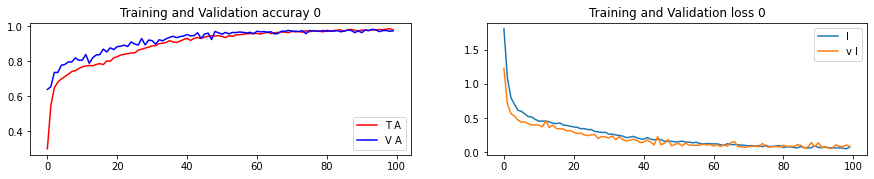

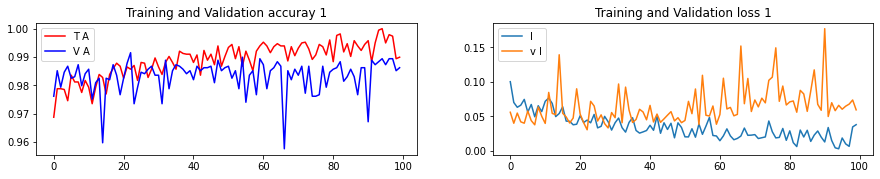

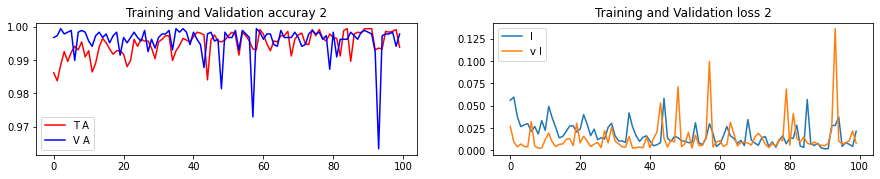

In [27]:
for i in range(3):
  acc = score[i].history['accuracy']
  loss = score[i].history['loss']
  val_acc = score[i].history['val_accuracy']
  val_loss = score[i].history['val_loss']
  #acc = history.history['accuracy']
  #val_acc = history.history['val_accuracy']
  #loss = history.history['loss']
  #val_loss = history.history['val_loss']
  plt.figure(figsize=(15,8))
  epochs = range(len(acc))
  plt.subplot(321)
  plt.plot(epochs, acc, 'r', label = 'T A')
  plt.plot(epochs, val_acc, 'b', label= 'V A')
  plt.title(f'Training and Validation accuray {i}')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,5))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

  plt.subplot(322)
  plt.plot(epochs, loss,'', label = 'l')
  plt.plot(epochs, val_loss,'', label = 'v l')
  plt.title(f'Training and Validation loss {i}')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,5))
  plt.subplots_adjust(wspace=0.2)
  #show the graph
plt.show()

In [35]:
 acc1 = score[0].history['accuracy']
 acc2 = score[1].history['accuracy']
 acc3 = score[2].history['accuracy']
 val1 = score[0].history['val_accuracy']
 val2 = score[1].history['val_accuracy']
 val3 = score[2].history['val_accuracy']

In [40]:
 loss1 = score[0].history['loss']
 loss2 = score[1].history['loss']
 loss3 = score[2].history['loss']
 val_loss1 = score[0].history['val_loss']
 val_loss2 = score[1].history['val_loss']
 val_loss3 = score[2].history['val_loss']

In [41]:
loss = [(loss1 + loss2 +loss3) / 3 for loss1,loss2,loss3 in zip(loss1,loss2,loss3)]
val_loss = [(val_loss1 + val_loss2 +val_loss2) / 3 for val_loss1,val_loss2,val_loss3 in zip(val_loss1,val_loss2,val_loss3)]

In [36]:
acur = [(acc1 + acc2 +acc3) / 3 for acc1,acc2,acc3 in zip(acc1,acc2,acc3)]
val = [(val1 + val2 +val3) / 3 for val1,val2,val3 in zip(val1,val2,val3)]

In [33]:
print(acur)

[0.751950204372406, 0.8371405998865763, 0.8722604910532633, 0.8843797842661539, 0.8878304958343506, 0.8963220119476318, 0.9005683660507202, 0.9055224458376566, 0.9064956704775492, 0.9105650385220846, 0.9135728875796, 0.9111854235331217, 0.9149001836776733, 0.9173763394355774, 0.9205609162648519, 0.9196769197781881, 0.9194110830624899, 0.9265766342480978, 0.9271956284840902, 0.9331228137016296, 0.9334771633148193, 0.9368387659390768, 0.9384310444196066, 0.9422343174616495, 0.9411733945210775, 0.944180428981781, 0.9490460356076559, 0.9493118723233541, 0.9515234231948853, 0.9538234273592631, 0.9566541115442911, 0.9566542704900106, 0.9622270464897156, 0.9636422793070475, 0.9618738492329916, 0.9655893047650655, 0.9655001362164816, 0.9651461640993754, 0.967623213926951, 0.9701887369155884, 0.972135066986084, 0.9693038662274679, 0.970896859963735, 0.974965512752533, 0.967712938785553, 0.9749657511711121, 0.9758506019910177, 0.9785925547281901, 0.9754085143407186, 0.9776197473208109, 0.9774424

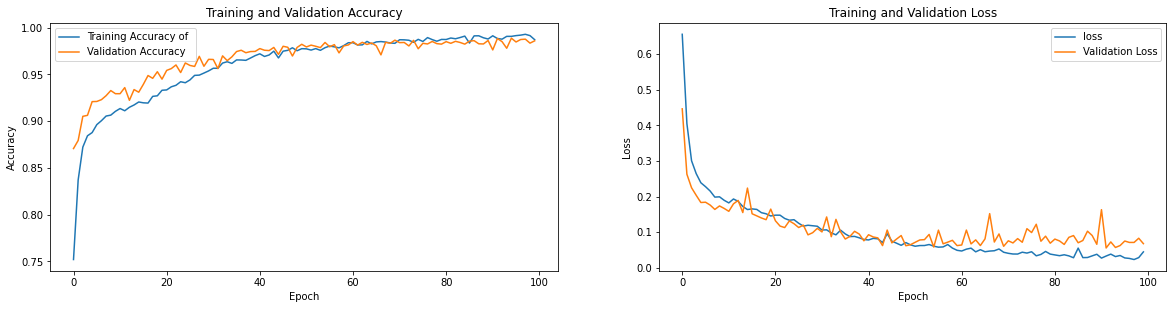

In [42]:
  plt.figure(figsize=(20,15))
  epochs = range(len(acc))
  plt.subplot(321)
  plt.plot(epochs, acur, label = 'Training Accuracy of ')
  plt.plot(epochs, val, label= 'Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

  plt.subplot(322)
  plt.plot(epochs, loss, label = 'loss ')
  plt.plot(epochs, val_loss, label= 'Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

In [53]:
train_pred =e_model.predict([x_te,x_te])
round_pred_t = np.argmax(train_pred,axis=-1)

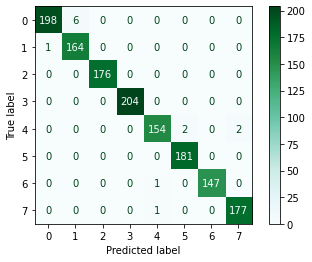

In [54]:
cm = confusion_matrix(y_te, round_pred_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='BuGn')#BuGn,GnBu,Greens,YlOrBr
plt.show()

### plot the result

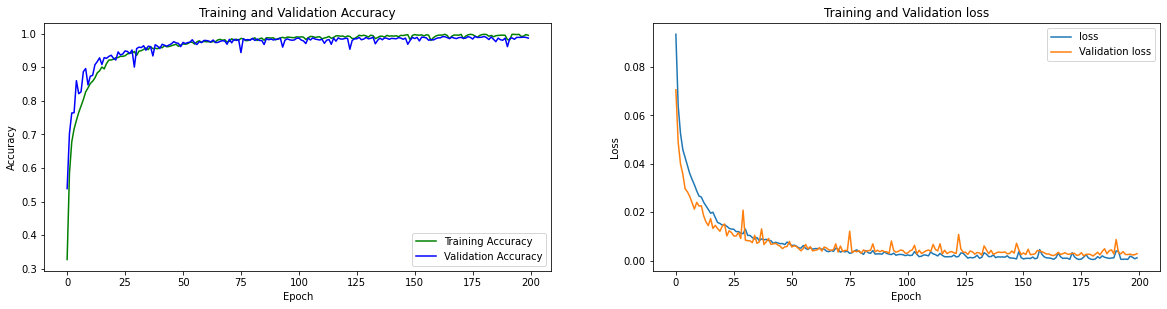

In [ ]:
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.figure(figsize=(20,15))
  epochs = range(len(acc))
  plt.subplot(321)
  plt.plot(epochs, acc, 'g', label = 'Training Accuracy')
  plt.plot(epochs, val_acc, 'b', label= 'Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2,bottom=0.1)

  plt.subplot(322)
  plt.plot(epochs, loss,'', label = 'loss')
  plt.plot(epochs, val_loss,'', label = 'Validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  #plt.figure(figsize=(10,10))
  plt.subplots_adjust(wspace=0.2)
  #show the graph
  plt.show()

### make prdiction and do confusion matrix

In [43]:
labeles = ['CBD','CB_Healthy','CWD','Healthy','Cercospora','Mold','Phoma','CLR']

In [44]:
target_names = ['CBD','CB_Healthy','CWD','Healthy','Cercospora','Mold','Phoma','CLR']

### confusion matrix Training

In [58]:
pip install pretty_confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 73 kB 1.1 MB/s 
     |████████████████████████████████| 199 kB 48.1 MB/s 
     |████████████████████████████████| 11.2 MB 60.2 MB/s 
     |████████████████████████████████| 103 kB 62.4 MB/s 
     |████████████████████████████████| 156 kB 58.6 MB/s 
     |████████████████████████████████| 843 kB 28.7 MB/s 
     |████████████████████████████████| 41 kB 372 kB/s 
     |████████████████████████████████| 68 kB 3.0 MB/s 
     |████████████████████████████████| 944 kB 14.3 MB/s 
     |████████████████████████████████| 10.1 MB 50.8 MB/s 
     |████████████████████████████████| 98 kB 785 kB/s 
     |████████████████████████████████| 596 kB 54.7 MB/s 
     |████████████████████████████████| 466 kB 69.1 MB/s 
  Attempting uninstall: tomli
    Found existing installation: tomli 2.0.1
    Uninstalling tomli-2.0.1:
      Successfully uninstalled tomli-2.0.1
  Att

In [59]:
from pretty_confusion_matrix import pp_matrix,pp_matrix_from_data

In [55]:
pred_tr = e_model.predict([x_tr,x_tr])
round_pred_tr = np.argmax(pred_tr,axis=-1)
y_tr_r = np.argmax(y_tr,axis=-1)
#print("Acuracy of the Testing is : " ,pred)

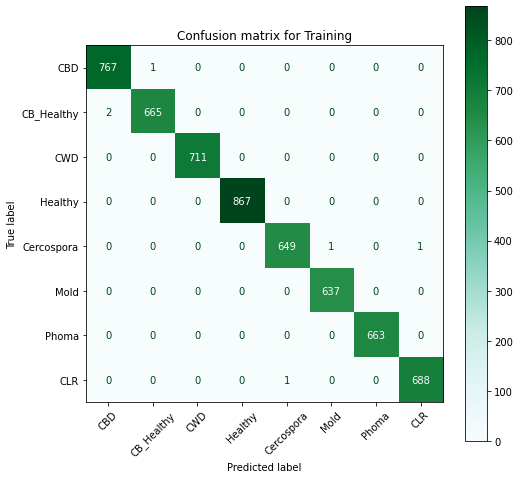

In [56]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_tr, round_pred_tr)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Training")
plt.show()

In [57]:
print(classification_report(y_tr,round_pred_tr,target_names=target_names))

              precision    recall  f1-score   support

         CBD       1.00      1.00      1.00       768
  CB_Healthy       1.00      1.00      1.00       667
         CWD       1.00      1.00      1.00       711
     Healthy       1.00      1.00      1.00       867
  Cercospora       1.00      1.00      1.00       651
        Mold       1.00      1.00      1.00       637
       Phoma       1.00      1.00      1.00       663
         CLR       1.00      1.00      1.00       689

    accuracy                           1.00      5653
   macro avg       1.00      1.00      1.00      5653
weighted avg       1.00      1.00      1.00      5653



/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

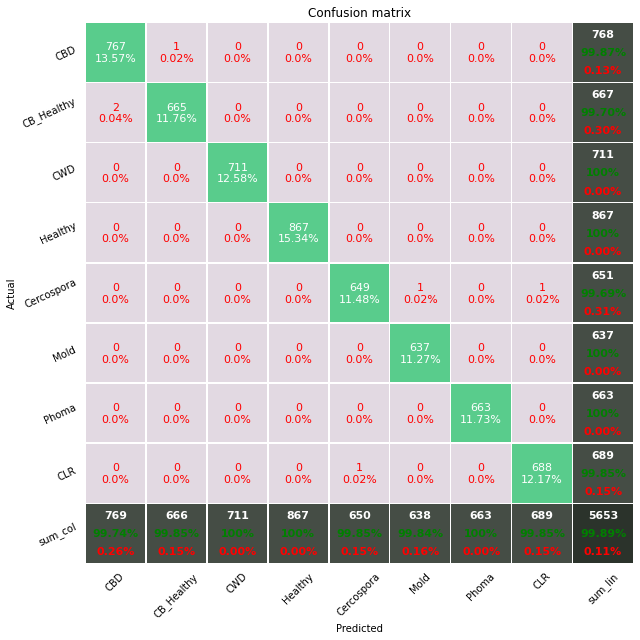

In [60]:
pp_matrix_from_data(y_tr, round_pred_tr,cmap='twilight',columns=labeles,figsize=[7,7],pred_val_axis='x')

### validation confusion matrix

In [ ]:
pred_v = e_model.predict([x_v,x_v])
round_pred_v = np.argmax(pred_v,axis=-1)
y_v_r = np.argmax(y_v,axis=-1)

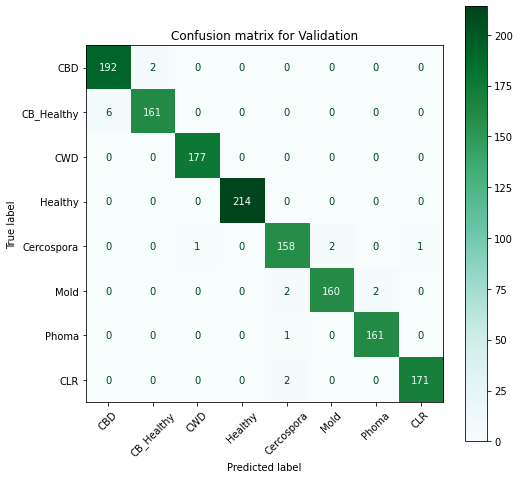

              precision    recall  f1-score   support

         CBD       0.97      0.99      0.98       194
  CB_Healthy       0.99      0.96      0.98       167
         CWD       0.99      1.00      1.00       177
     Healthy       1.00      1.00      1.00       214
  Cercospora       0.97      0.98      0.97       162
        Mold       0.99      0.98      0.98       164
       Phoma       0.99      0.99      0.99       162
         CLR       0.99      0.99      0.99       173

    accuracy                           0.99      1413
   macro avg       0.99      0.99      0.99      1413
weighted avg       0.99      0.99      0.99      1413



In [ ]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_v_r, round_pred_v)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Validation")
plt.show()
print(classification_report(y_v_r,round_pred_v,target_names=target_names))

/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

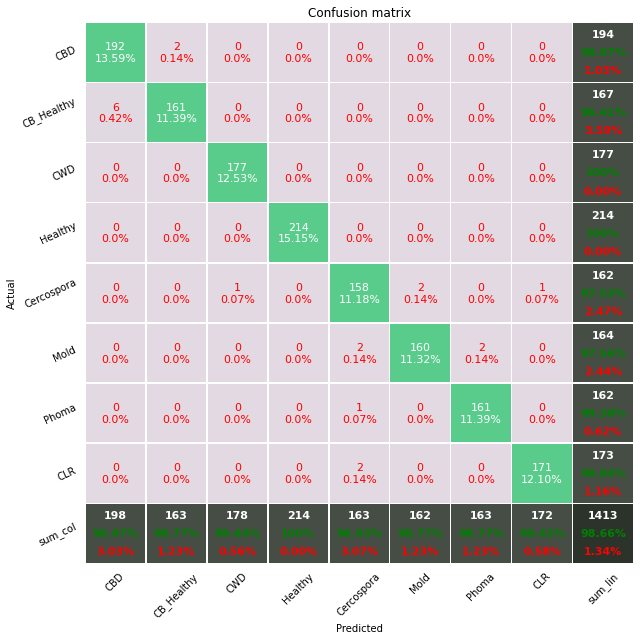

In [ ]:
pp_matrix_from_data(y_v_r, round_pred_v,cmap='twilight',columns=labeles,figsize=[7,7],pred_val_axis='x')

### confusion matrix Testing

In [51]:
pred_t = e_model.predict([x_te,x_te])
round_pred_t = np.argmax(pred_t,axis=-1)
y_tes_r = np.argmax(y_te,axis=-1)

TypeError: ignored

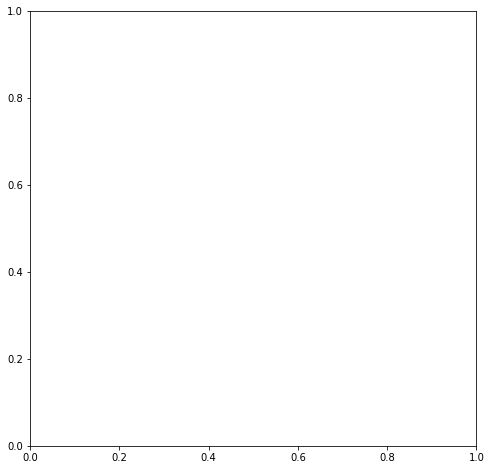

In [52]:
fig,ax = plt.subplots(figsize=(8,8)) 
cm = confusion_matrix(y_tes_r, round_pred_t)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labeles)
disp.plot(cmap='BuGn',ax = ax,xticks_rotation=45)
disp.ax_.set_title("Confusion matrix for Testing")
plt.show()
print(classification_report(y_tes_r,round_pred_t,target_names=target_names))

/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.7/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

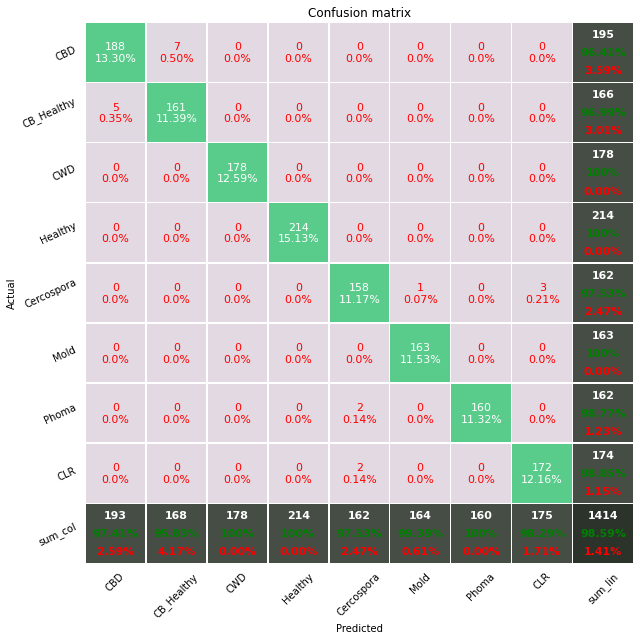

In [ ]:
pp_matrix_from_data(y_tes_r, round_pred_t,cmap='twilight',columns=labeles,figsize=[7,7],pred_val_axis='x')